In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import time



# Parameters
#input and output band size
classes = ('negative', 'positive')
n_classes = len(classes)
n_epoch = 20
batch_size = 20
learning_rate = 0.1
cuda=False

training_dir = "imaget_data/training_set"
test_dir = "imaget_data/test_set"

In [4]:
#.Compose allows for multiple manipulations
#COnvert dataset into a Pytorch Tensor and normalise the data so the NN trains better
#TODO: instead of a standard normalisation for each input channel (RGB), supply it with ((mean,), (std,)) of the datasets channels
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

# Datasets and loaders
#Dataset reads and transforms an image in a dataset.
train_set = datasets.ImageFolder(root=os.path.join(training_dir), transform=transform)
test_set = datasets.ImageFolder(root=os.path.join(test_dir), transform=transform)

#Dataloader is used to shuffle the data and segment it into batches, then load it in parrelel using workers
#Sample specified therefore shuffle must be false, and perfromed in the indices
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images shape on batch size = torch.Size([20, 3, 256, 256])
labels shape on batch size = torch.Size([20])


/home/vanguard/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


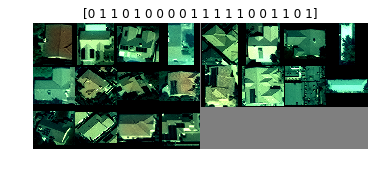

negative positive positive negative positive negative negative negative negative positive positive positive positive positive negative negative positive positive negative positive


In [5]:
import matplotlib.pyplot as plt
import numpy as np

'''
function to show an image batch for Dataloader
'''
def imshow(img):
    # unnormalize, reshape
    img = img / 2 + 0.5
    npimg = img.numpy()
    np.transpose(npimg, (1, 2, 0))

    #show
    plt.figure()
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(labels.numpy())
    plt.show()

# get some images
images, labels = next(iter(train_loader))


print(f'images shape on batch size = {images.size()}')
print(f'labels shape on batch size = {labels.size()}')

# show images
imshow(torchvision.utils.make_grid(images))

# print labels for images
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # create hidden layers and assign these layers to self
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # output of layer 1 will be 128x128 imagets w 8 channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # output of layer 2 will be 64x64 imagets w 16 channels
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # output of layer 3 will be 32x32 imagets w 32 channels
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # output of layer 4 will be 16x16 imagets w 64 channels
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        #TODO: W14 due to padding??
        # fully connected layers
        #1st layer size 64*8*8 nodes connected to 2nd layers of
        self.fc1 = nn.Linear(64*14*14, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


model = Net(n_classes)


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() >= 1:
    cuda = True
    print("Let's use", torch.cuda.device_count(), "GPUs!")
else:
    print("using cpu")

# cast model to CPU or GPU if available
model.to(device=device, dtype=torch.float)

Let's use 1 GPUs!


Net(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=12544, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)